In [61]:
from google.colab import drive

drive.mount('/content/drive')

excel_file_path = '/content/drive/My Drive/sp500esg.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
# Plotly.express module can plot interactive plots easily and effectively.

In [63]:
# Read Excel file into a DataFrame
stocks_df = pd.read_excel(excel_file_path)
stocks_df = stocks_df.dropna()
stocks_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
stocks_df

,date,SPESG,VWG,SEIM,ADD,BMW
0,2023-01-04,161.83,125.879997,17.930935,137.800446,17.930935
1,2023-01-05,161.64,127.120003,17.607719,137.959778,17.607719
2,2023-01-06,163.51,128.160004,18.229286,140.090805,18.229286
3,2023-01-09,164.87,128.020004,18.080111,141.066711,18.080111
4,2023-01-10,164.02,127.279999,17.567942,139.513245,17.567942
...,...,...,...,...,...,...
245,2023-12-27,175.49,112.800003,11.915000,185.559998,11.915000
246,2023-12-28,175.29,112.160004,11.800000,184.100006,11.800000
247,2023-12-29,175.70,111.800003,12.000000,184.160004,12.000000
248,2024-01-02,175.50,112.879997,11.885000,182.220001,11.885000


In [64]:
# Normalizing scores for comparison
def normalize_stocks(df):
    df_ = df.copy() # it is a good idea in general to make a copy
    for stock in df_.columns[1:]:
        df_[stock] = df_[stock] / df_.loc[0, stock]
    return df_

norm_stocks_df = normalize_stocks(stocks_df)
norm_stocks_df.head(5)

,date,SPESG,VWG,SEIM,ADD,BMW
0,2023-01-04,1.000000,1.000000,1.000000,1.000000,1.000000
1,2023-01-05,0.998826,1.009851,0.981974,1.001156,0.981974
2,2023-01-06,1.010381,1.018113,1.016639,1.016621,1.016639
3,2023-01-09,1.018785,1.017000,1.008319,1.023703,1.008319
4,2023-01-10,1.013533,1.011122,0.979756,1.012430,0.979756


In [65]:
# visualisation
fig = px.line(title = "Normalized stock prices")

# Loop through each stock (while ignoring time columns with index 0)
for stock in norm_stocks_df.columns[1:]:
    fig.add_scatter(x = norm_stocks_df['date'], y = norm_stocks_df[stock], name = stock)
fig.show()

In [66]:
# function to calculate daily stock returns
def daily_return_estimator(df):
    df_daily_return = df.copy()

# Loop through each stock (column of the dataframe except Date collumn)
    for i in df.columns[1:]:

        # Loop through each row/price belonging to the stock
        for j in range(1, len(df)):

            # Calculate the percentage of change from the previous day's close price.
            # Simple equation of percentage change.
            df_daily_return[i][j] = ((df[i][j]- df[i][j-1])/df[i][j-1]) * 100

         # set the value of first row to zero (previous value is not available)
        df_daily_return.loc[0, i] = 0

    return df_daily_return

In [67]:
stocks_daily_return = daily_return_estimator(stocks_df)
stocks_daily_return.head(5)

,date,SPESG,VWG,SEIM,ADD,BMW
0,2023-01-04,0.000000,0.000000,0.000000,0.000000,0.000000
1,2023-01-05,-0.117407,0.985070,-1.802561,0.115625,-1.802561
2,2023-01-06,1.156892,0.818125,3.530082,1.544673,3.530082
3,2023-01-09,0.831753,-0.109238,-0.818326,0.696624,-0.818326
4,2023-01-10,-0.515558,-0.578039,-2.832776,-1.101228,-2.832776


In [68]:
for i, stock in enumerate(stocks_daily_return.columns):
  print(i, stock)

0 date
1 SPESG
2 VWG
3 SEIM
4 ADD
5 BMW


Text(0.5, 1.0, 'Daily returns of the stocks')

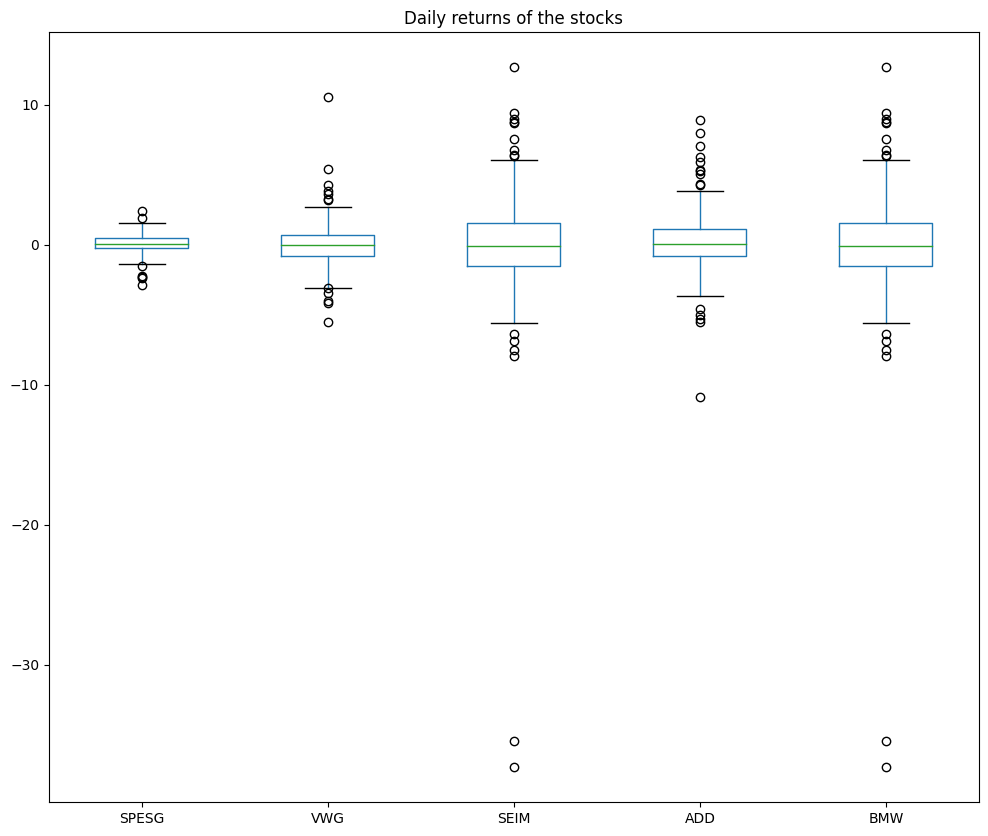

In [69]:
# Boxplots
# Histogram of daily returns (in %)

stocks_daily_return.boxplot(figsize=(12, 10), grid=False)
plt.title("Daily returns of the stocks")

Text(0.5, 0.98, 'Beta estimation: regression between S&P 350 ESG index and individual stock daily performance')

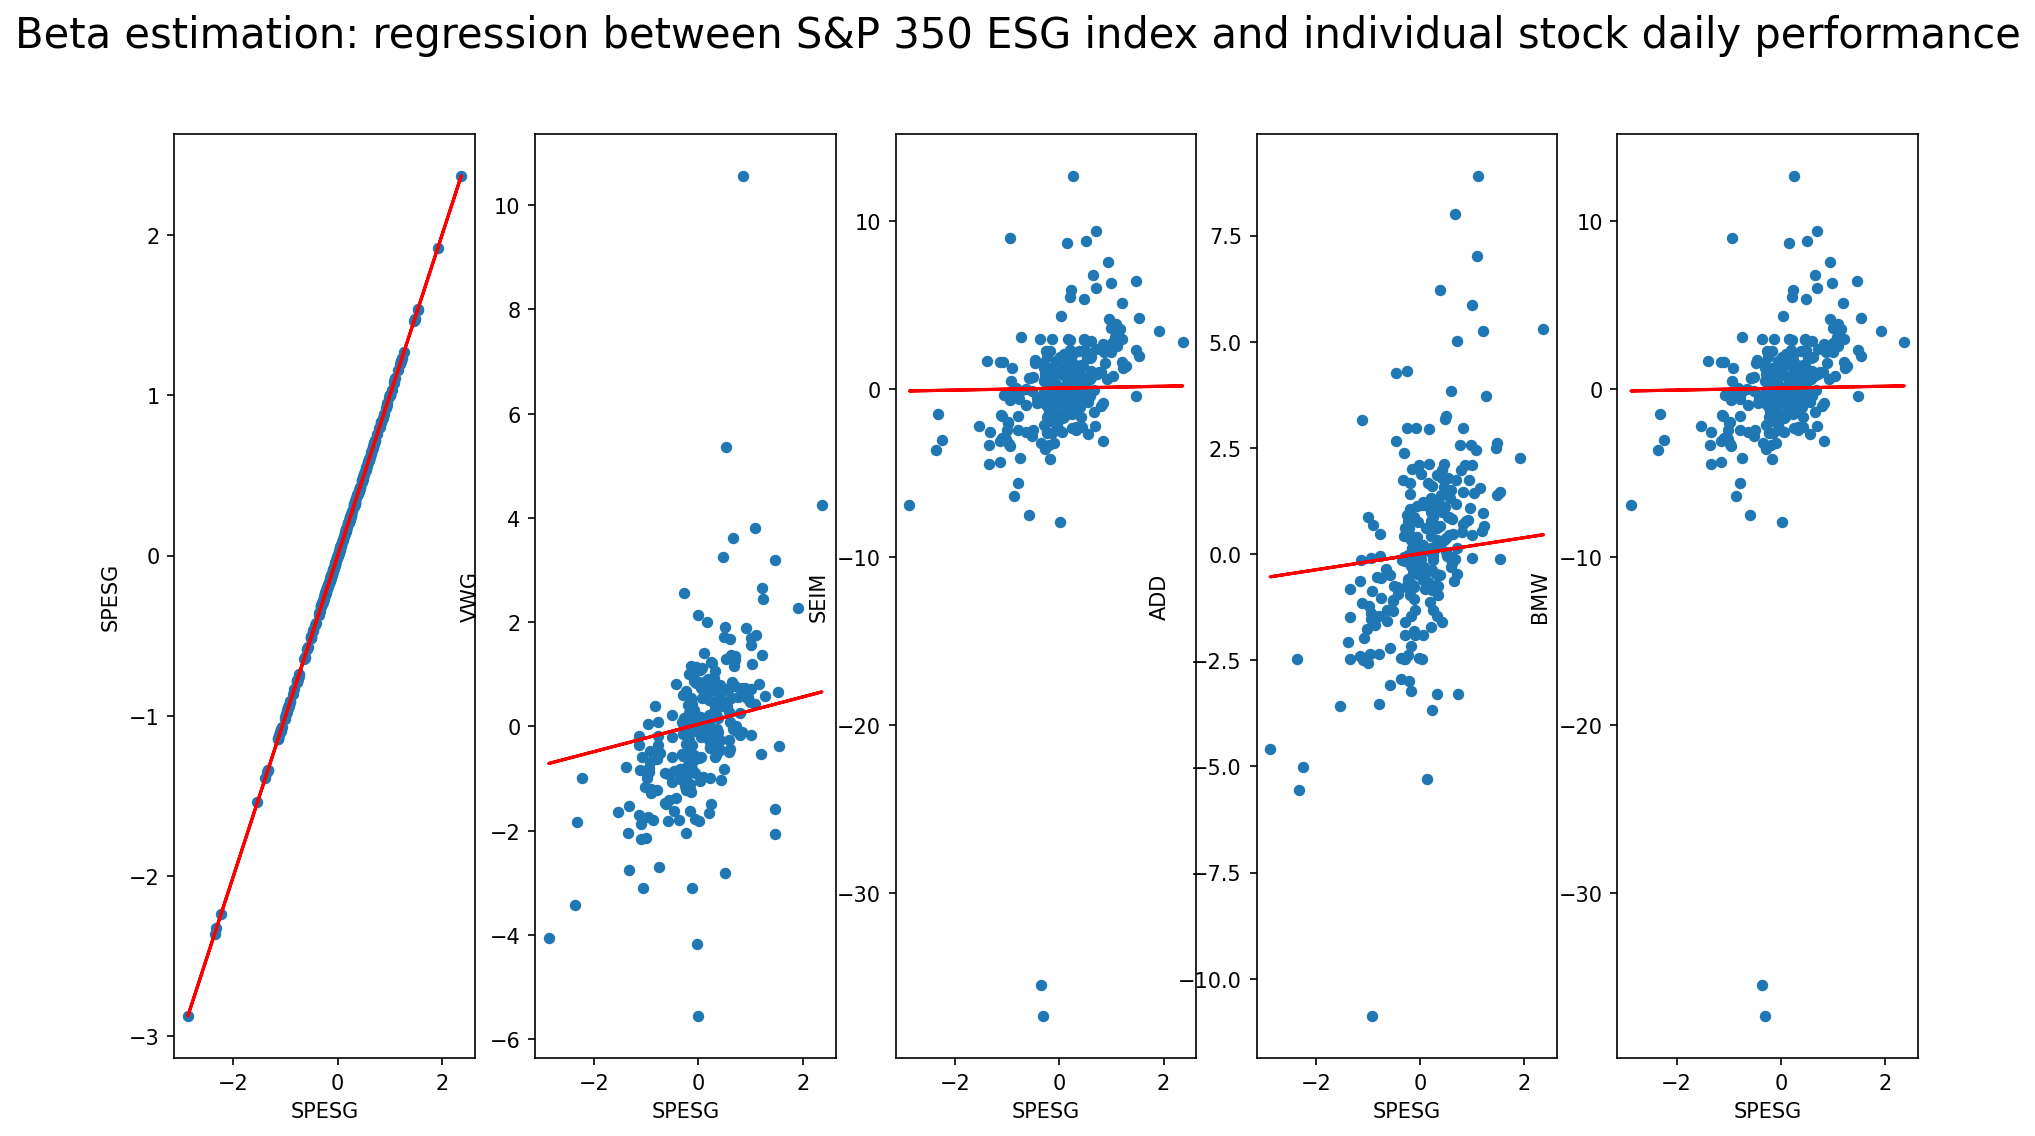

In [77]:
# CAPM model
# Initialize empty dictionaries to save results
beta,alpha = dict(), dict()

# Make a nice subplot
fig, axes = plt.subplots(1,5, dpi=150, figsize=(15,8))
axes = axes.flatten()

plot_count = 0

# Loop on every stock daily return
for idx, stock in enumerate(stocks_daily_return.columns):

  # Ignoring the date and S&P350 ESG Columns
    if stock != "date":
        # scatter plot between stock and the S&P500
        stocks_daily_return.plot(kind = "scatter", x = "SPESG", y = stock, ax=axes[idx-1])

        # Fit a line (regression using polyfit of degree 1)
        b_, a_ = np.polyfit(stocks_daily_return[stock], stocks_daily_return["SPESG"], 1)

        regression_line = b_ * stocks_daily_return["SPESG"] + a_
        axes[idx-1].plot(stocks_daily_return["SPESG"], regression_line, "-", color = "r")

        # save the regression coeeficient for the current stock
        beta[stock] = b_
        alpha[stock] = a_

plt.suptitle("Beta estimation: regression between S&P 350 ESG index and individual stock daily performance", size=20)

In [71]:
beta

{'VWG': 0.26217418099947226,
 'SEIM': 0.05758079932358434,
 'ADD': 0.18923214695860313,
 'BMW': 0.05758079932358434}

In [72]:
# Initialize the expected return dictionary
ER = dict()
rf = 0 # assume risk-free rate is zero in this case

# Estimate the expected return of the market using the daily returns
rm = stocks_daily_return["SPESG"].mean() * 253

In [73]:
keys = list(beta.keys())
for k in keys:
    # Calculate return for every security using CAPM
    ER[k] = rf + beta[k] * (rm-rf)

for k in keys:
    print("Expected return based on CAPM model for {} is {}%".format(k, ER[k]))

Expected return based on CAPM model for VWG is 2.0911582475610473%
Expected return based on CAPM model for SEIM is 0.45927696979022253%
Expected return based on CAPM model for ADD is 1.5093567311151954%
Expected return based on CAPM model for BMW is 0.45927696979022253%


In [74]:
for k in keys:
    print('Return based on historical data for {} is {}%'.format(k, stocks_daily_return[k].mean() * 252))

Return based on historical data for VWG is -10.056707327755124%
Return based on historical data for SEIM is -20.96465560366455%
Return based on historical data for ADD is 32.23778226409808%
Return based on historical data for BMW is -20.96465560366455%


In [75]:
stocks_daily_return['SPESG'].mean() * 252

7.944690785346332